# Lab 11
Bruce Cai

Using the brain tumor data included in the ISLP library, complete the following: 

1. Plot the Kaplan-Meier survival curve with ±1 standard error bands, using the KaplanMeierFitter() estimator in the lifelines package.



In [15]:
from matplotlib.pyplot import subplots
import numpy as np
import pandas as pd
from ISLP.models import ModelSpec as MS
from ISLP import load_data
from lifelines import \
     (KaplanMeierFitter,
      CoxPHFitter)
from lifelines.statistics import \
     (logrank_test,
      multivariate_logrank_test)
from ISLP.survival import sim_time
import matplotlib.pyplot as plt

<Axes: xlabel='timeline'>

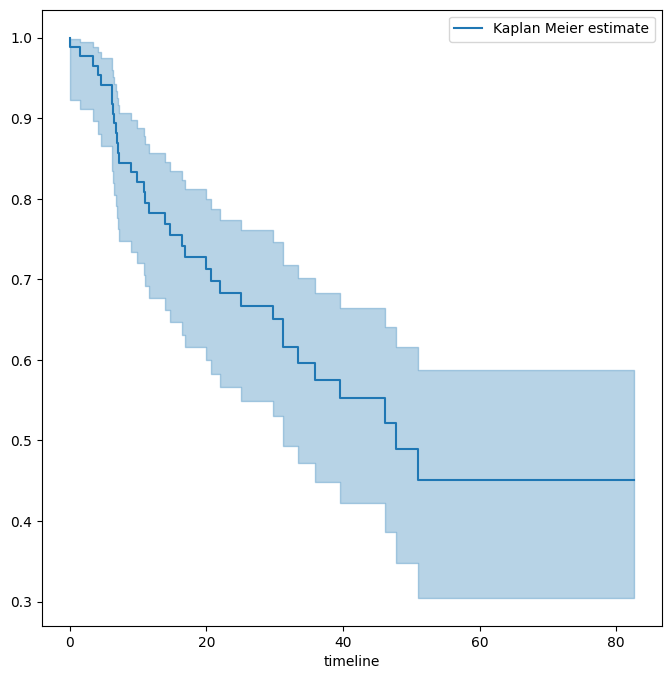

In [16]:
BrainCancer = load_data('BrainCancer')
fig, ax = subplots(figsize=(8,8))
km = KaplanMeierFitter()
km_brain = km.fit(BrainCancer['time'], BrainCancer['status'])
km_brain.plot(label='Kaplan Meier estimate', ax=ax,ci_alpha=0.32)

2. Draw a bootstrap sample of size n = 88 from the pairs (yI , 
i) and compute the resulting Kaplan-Meier survival curve. Repeat this process B = 200 times. Use the results to obtain an estimate of the standard error of the Kaplan-Meier survival curve at each timepoint. Compare this to the standard errors obtained in (a).

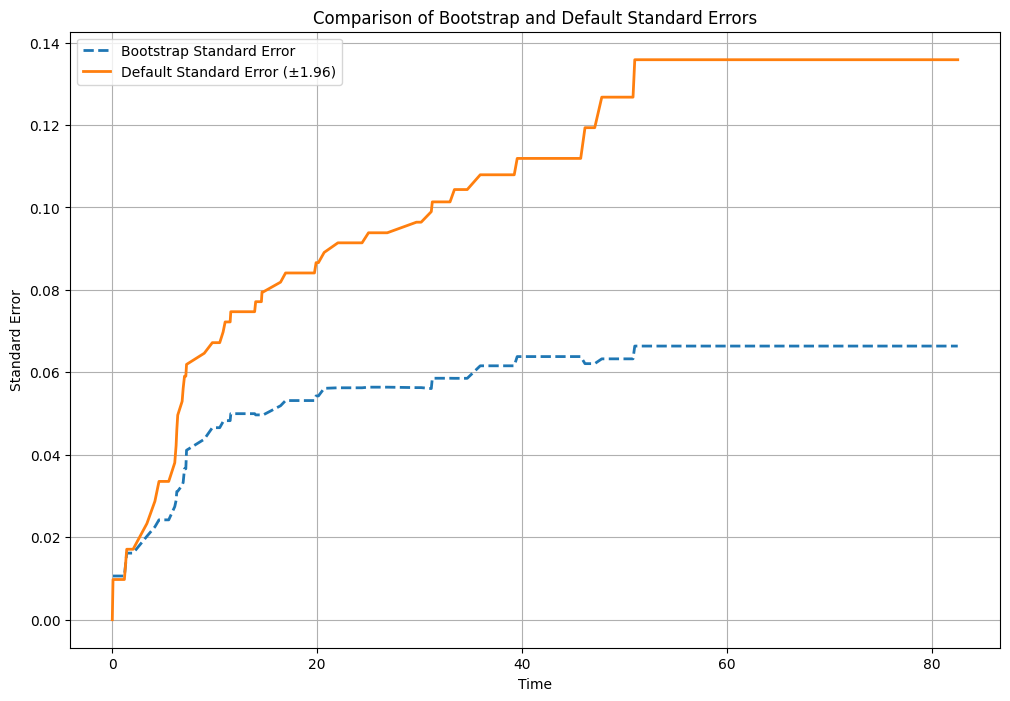

In [17]:
n = 88  # Sample size
B = 200  # Number of bootstrap samples

# Prepare the data for bootstrapping
survival_times = BrainCancer['time']
event_observed = BrainCancer['status']
time_points = np.unique(survival_times)  # Unique survival times

# Storage for bootstrap estimates
bootstrap_survival_curves = np.zeros((B, len(time_points)))

# Perform bootstrap sampling
for b in range(B):
    # Bootstrap sampling (with replacement)
    sample_indices = np.random.choice(len(survival_times), size=n, replace=True)
    sample_survival_times = survival_times.iloc[sample_indices]
    sample_event_observed = event_observed.iloc[sample_indices]

    # Fit Kaplan-Meier curve on bootstrap sample
    km.fit(durations=sample_survival_times, event_observed=sample_event_observed)
    bootstrap_survival_curves[b, :] = km.survival_function_at_times(time_points).values

# Compute standard error at each time point
bootstrap_std_errors = np.std(bootstrap_survival_curves, axis=0)

# Fit Kaplan-Meier on original data to compare standard errors
km.fit(durations=survival_times, event_observed=event_observed)

# Plot comparison of bootstrap and default standard errors
plt.figure(figsize=(12, 8))
plt.plot(time_points, bootstrap_std_errors, label="Bootstrap Standard Error", linestyle='--', linewidth=2)
plt.plot(km.confidence_interval_.index, 
         (km.confidence_interval_["KM_estimate_upper_0.95"] - km.survival_function_["KM_estimate"]).values, 
         label="Default Standard Error (±1.96)", linewidth=2)
plt.title("Comparison of Bootstrap and Default Standard Errors")
plt.xlabel("Time")
plt.ylabel("Standard Error")
plt.legend()
plt.grid(True)
plt.show()

3. Fit a Cox proportional hazards model that uses all of the predictors to predict survival. Summarize the main findings.

In [22]:
cph = CoxPHFitter()

print(BrainCancer.head(3))
BrainCancer = BrainCancer.dropna()

# Perform one-hot encoding for all categorical columns
data_encoded = pd.get_dummies(BrainCancer, columns=["sex", "diagnosis", "loc", "stereo"], drop_first=True)

cph.fit(data_encoded, duration_col="time", event_col="status")

# Print a summary of the model
cph.print_summary()

      sex   diagnosis             loc  ki    gtv stereo  status   time
0  Female  Meningioma  Infratentorial  90   6.11    SRS       0  57.64
1    Male   HG glioma  Supratentorial  90  19.35    SRT       1   8.98
2  Female  Meningioma  Infratentorial  70   7.95    SRS       0  26.46


<lifelines.CoxPHFitter: fitted with 87 total observations, 52 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 87
number of events observed = 35
   partial log-likelihood = -116.75
         time fit was run = 2024-11-16 06:04:28 UTC

---
                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                             
ki                   -0.05      0.95      0.02           -0.09           -0.02                0.91                0.98
gtv                   0.03      1.03      0.02           -0.01            0.08                0.99                1.08
sex_Male              0.18      1.20      0.36           -0.52            0.89                0.59                2.44
diagnosis_LG glioma  -1.24      0.29      0.58           -2.38           -0.10                0.09                0.90
diagnosis_Meningioma -2.15      0.12      0.45           -3.04           -1.27                0.05                0.28
diagnosis_Other      -1.27      0.28      0.62           -2.48           -0.06                0.08                0.94
loc_Supratentorial    0.44      1.55      0.70           -0.94            1.82                0.39                6.17
stereo_SRT            0.18      1.19      0.60           -1.00            1.36                0.37                3.88

                      cmp to     z      p  -log2(p)
covariate                                          
ki                      0.00 -3.00 <0.005      8.54
gtv                     0.00  1.54   0.12      3.00
sex_Male                0.00  0.51   0.61      0.71
diagnosis_LG glioma     0.00 -2.14   0.03      4.95
diagnosis_Meningioma    0.00 -4.78 <0.005     19.14
diagnosis_Other         0.00 -2.05   0.04      4.65
loc_Supratentorial      0.00  0.63   0.53      0.91
stereo_SRT              0.00  0.30   0.77      0.38
---
Concordance = 0.79
Partial AIC = 249.50
log-likelihood ratio test = 41.37 on 8 df
-log2(p) of ll-ratio test = 19.10

4. Stratify the data by the value of ki. (Since only one observation has ki==40, you can group that observation together with the observations that have ki==60.) Plot Kaplan-Meier survival curves for each of the five strata, adjusted for the other predictors.

C:\Users\bruce\AppData\Local\Temp\ipykernel_22948\2304811495.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BrainCancer['ki_grouped'] = BrainCancer['ki'].replace(40, 60)


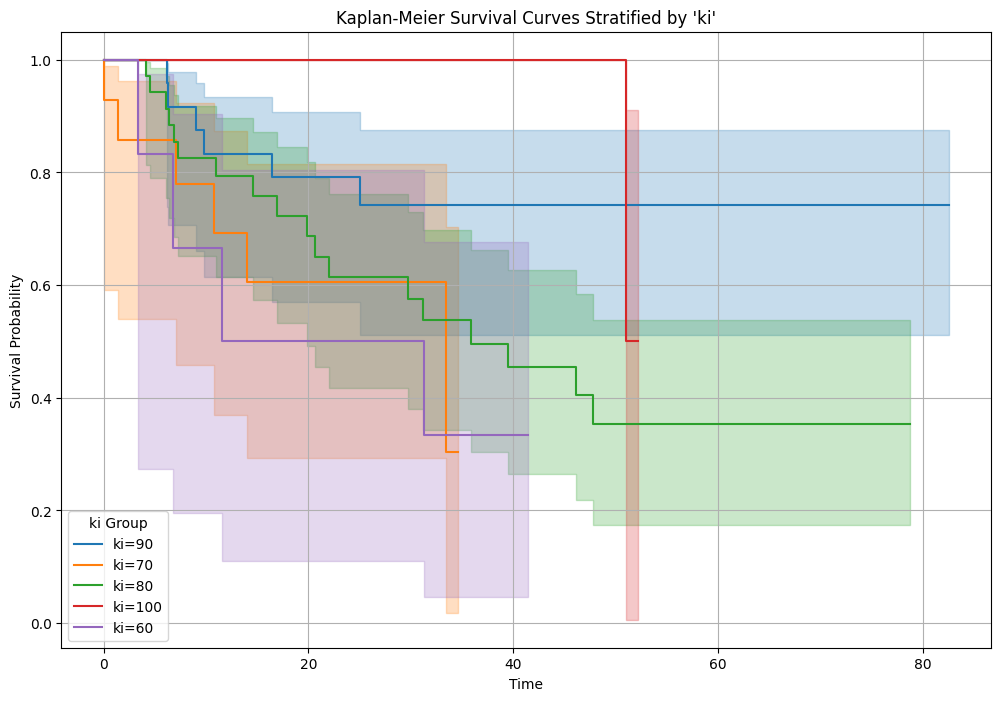

In [23]:
BrainCancer['ki_grouped'] = BrainCancer['ki'].replace(40, 60)

# Unique strata based on grouped 'ki' values
strata_groups = BrainCancer['ki_grouped'].unique()




kmf = KaplanMeierFitter()

# Plot Kaplan-Meier survival curves for each strata
plt.figure(figsize=(12, 8))
for group in strata_groups:
    group_data = BrainCancer[BrainCancer['ki_grouped'] == group]
    kmf.fit(durations=group_data['time'], event_observed=group_data['status'], label=f"ki={group}")
    kmf.plot_survival_function()

# Adjust plot settings
plt.title("Kaplan-Meier Survival Curves Stratified by 'ki'")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.legend(title="ki Group")
plt.show()